In [1]:
import sys
if 'ipykernel_launcher.py' not in sys.argv[0]:
    manual = False
    scenario = sys.argv[1]
else:
    manual = True
    scenario = 'ref_18'
    %matplotlib inline

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np

work_path = r'../../'
quetzal_path = work_path + r'model/'
plot_path = work_path + r'outputs/plot/detail/'

import sys
sys.path.insert(0, '../../../quetzal/')

from quetzal.model import stepmodel

SQLalchemy is not installed. No support for SQL output.


In [3]:
from shapely import geometry

In [4]:
sm =  stepmodel.read_zip(quetzal_path + scenario +  '/assigned.zip')

zones: 100%|███████████████████████████████████████████████████████████████████████████| 35/35 [00:48<00:00,  1.39s/it]


In [5]:
sm.volumes.loc[sm.volumes['origin'] == sm.volumes['destination'], ['car', 'nocar']] = 0 

In [6]:
sm.loaded_links = sm.links

# maps

In [7]:
from syspy.syspy_utils import data_visualization as dv
from syspy.syspy_utils import syscolors
spectral = list(reversed(['#9e0142','#d53e4f','#f46d43','#fdae61','#fee08b','#e6f598','#abdda4','#66c2a5','#3288bd','#5e4fa2']))
from tqdm import tqdm

In [8]:
def link_plot(scenario, sm, *args, **kwargs):
    sm = sm.copy()
    l = gpd.GeoDataFrame(sm.links.copy()).dropna(subset=['route_type'])

    d = {
        'subway': syscolors.rainbow_shades[0],
        'tram': syscolors.rainbow_shades[1],
        'express_bus': syscolors.rainbow_shades[1],
        'gondola': syscolors.rainbow_shades[3],
    }
    
    road_ax = sm.plot('road_links', color='grey', linewidth=0.05, figsize=[17, 15])
    #road_ax = sm.plot('links', color='grey', linewidth=0.05, figsize=[17, 15])

    for route_type, color in d.items():
        
        p = l.copy()
        p = p.loc[p['route_type'] == route_type]
        if len(p):
            p.plot(linewidth=5, color=color, ax=road_ax, *args, **kwargs) #, ax=road_ax
            p = p.loc[p['route_id'].isin(['m1', 'm2', 'tele_este'])]
            if len(p):
                p.plot(linewidth=5, color=color, ax=road_ax)
        
    plot = road_ax
    
    plot.set_yticks([])
    plot.set_xticks([])
    
    title = 'lines_%s' % scenario
    plot.set_title(title)
    fig = plot.get_figure()
    fig.savefig(plot_path + title + '.png', bbox_inches='tight')

In [9]:
sm.loaded_links[('volume', 'pt')] = sm.loaded_links['volume']

In [10]:
def bandwidth(df, value, power=1, scale=1, legend_values=None, cmap=spectral, dynamic_width=True,  n_category=10, *args, **kwargs):

    if legend_values is None:
        s = df[value].copy()
        r = int(np.log10(s.mean())) 
        legend_values = [np.round(s.quantile(i/5), -r) for i in range(6)]
    
    df = df[[value, 'geometry']].copy().fillna(0)
    df = df.loc[df[value] > 0]
    mls = geometry.MultiPoint(list(df['geometry'].apply(lambda g: g.centroid)))

    b = mls.bounds
    delta = b[2] - b[0]
    rank = 0
    dx = delta /3 / len(legend_values)
    data = []
    for v in reversed(legend_values):
        g = geometry.LineString([
            ( b[2] - rank * dx, (b[1] + b[1]) / 2),
            ( b[2] - (rank + 1)*dx, (b[1] + b[1]) / 2)]
        )
        rank += 1
        data.append([v, g, str(v)])
        to_concat = pd.DataFrame(data, columns=[value, 'geometry', 'label'])
    df = pd.concat([df, to_concat])
    
    df = df.loc[df[value] > 0]
    plot = gpd.GeoDataFrame(df).plot(linewidth=0.1, color='grey', *args, **kwargs)
    
    power_series = (np.power(df[value], power))
    max_value = power_series.max()
    

    ratio = n_category / power_series.max()
    df['cat'] = np.round(power_series * ratio).fillna(0) - 1
    df = df.loc[df['cat']> 0]

    plot.set_yticks([])
    plot.set_xticks([])
    
    color_dict = dv.color_series(pd.Series(range(n_category)), cmap).to_dict()
    for cat in tqdm(set(df['cat'])):
        linewidth = cat*scale if dynamic_width else scale
        pool = df.loc[df['cat'] == cat]
        plot = gpd.GeoDataFrame(pool).plot(linewidth=linewidth, ax=plot, color=color_dict[int(cat)]) 
       

    to_concat.apply(
        lambda x: plot.annotate(
            s=x[value], xy=x.geometry.centroid.coords[0], ha='center', va='bottom'
        ),axis=1
    )
    return plot

def loaded_plot(scenario, sm, *args, **kwargs):
    sm = sm.copy()

    i_links = sm.loaded_links.loc[sm.loaded_links.road_length.isnull()]
    df = pd.concat([i_links, sm.road_links])
    columns = [('nocar', 'pt'), ('car', 'pt'), ('car', 'car'), 'geometry']
    df['pt'] = df[('volume', 'pt')].fillna(0) 
    df['car'] = df[('volume', 'car')].fillna(0)
    df['total'] = df['pt'] + df['car']
    
    for column in ['pt', 'car', 'total']:
        #road_ax = sm.plot('road_links', color='grey', linewidth=0.05, figsize=[17, 15])
        road_ax = sm.plot('links', color='grey', linewidth=0.05, figsize=[17, 15])
        plot = bandwidth(df.loc[df[column] > 0], value=column, figsize=[17, 15], ax=road_ax,*args, **kwargs)

        title = 'loaded_%s_%s' % (column, scenario)
        plot.set_title(title)
        fig = plot.get_figure()
        fig.savefig(plot_path + title + '.png', bbox_inches='tight', dpi=300)


In [11]:
sm.car_los = sm.los.loc[sm.los['route_type'] == 'car']
sm.pt_los = sm.los.loc[sm.los['route_type'] != 'car']

In [12]:
import os
try:
    os.mkdir('../../outputs')
except FileExistsError:
    pass
try:
    os.mkdir('../../outputs/plot')
except FileExistsError:
    pass
try:
    os.mkdir('../../outputs/plot/detail')
except FileExistsError:
    pass

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  3.94it/s]


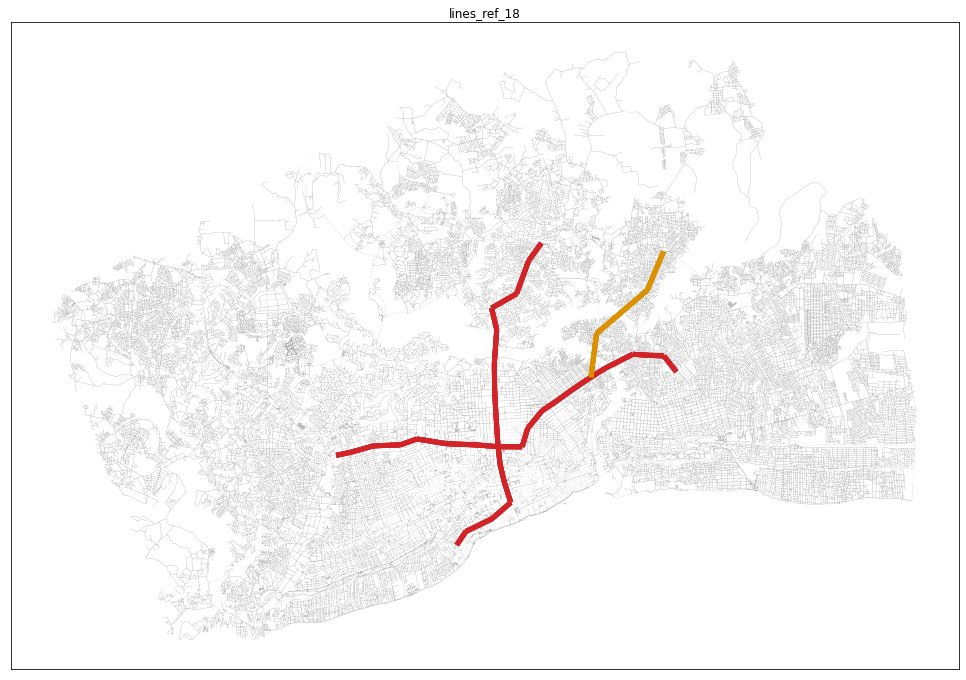

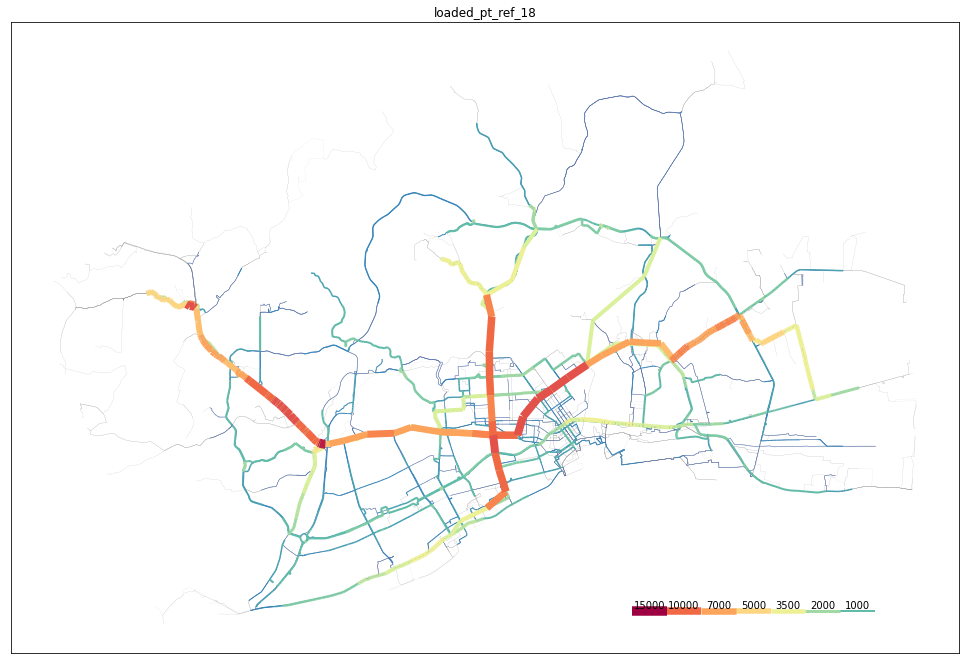

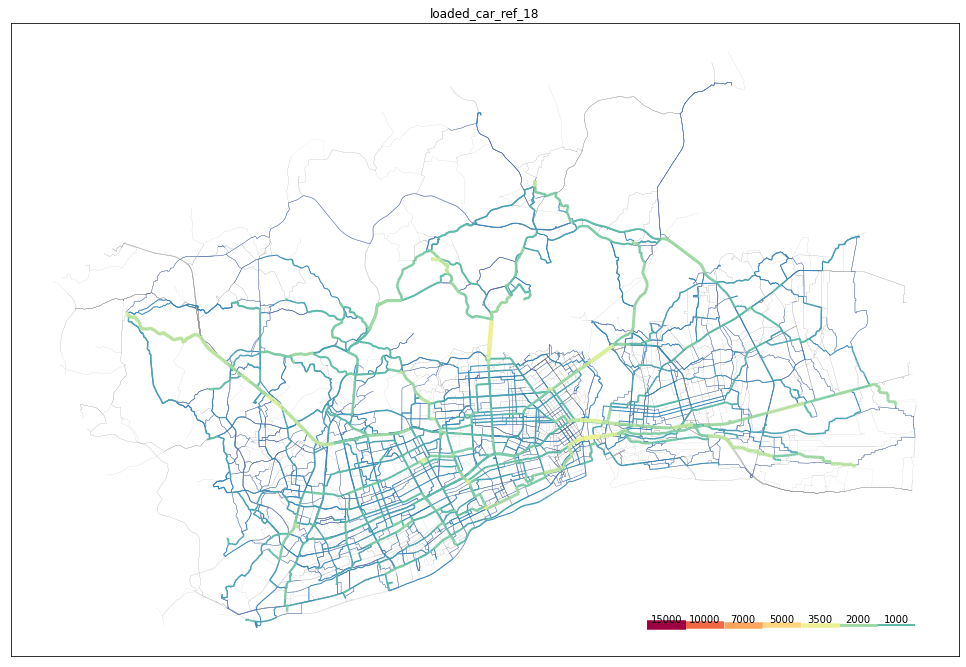

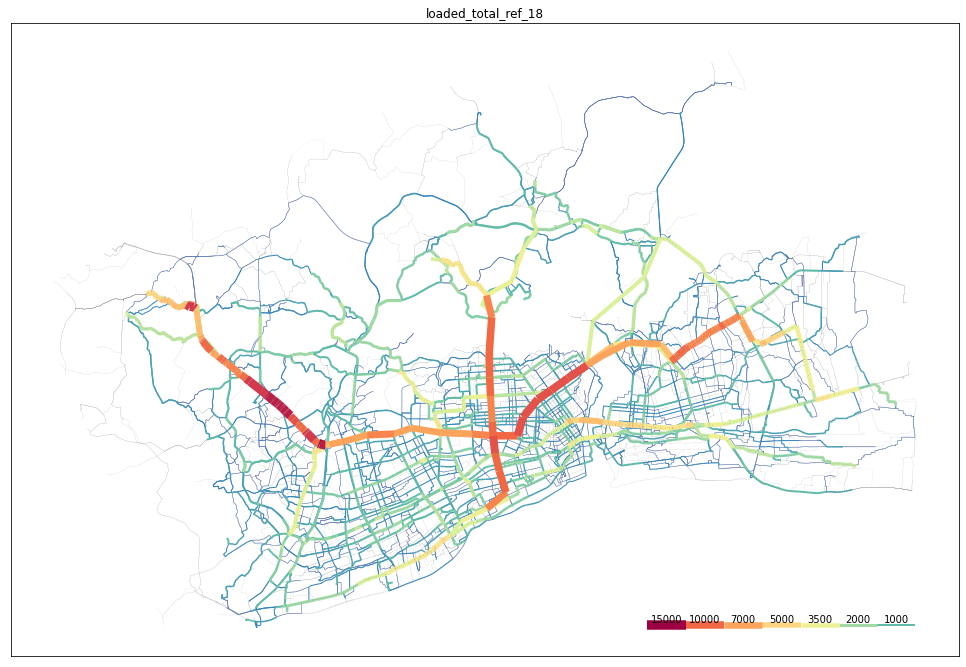

In [13]:
link_plot(scenario=scenario ,sm=sm)
loaded_plot(scenario=scenario,sm=sm, n_category=20, scale=0.5, power=0.5, 
            legend_values=(15000, 10000, 7000,  5000, 3500, 2000, 1000))